กลุ่ม Fruit Recognition จัดทำโดย
1.   ณัทธร เชิงเชาว์ 6209610416
2.   ณัฐนนท์ ราษฎร์บริรักษ์ 6209680799
3.   สิรวิชญ์ คล้ายรัศมี 6209680831

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import os
IMG_PATH_TRAIN = "/content/drive/MyDrive/fruits_dataset/Fruit_Training"
IMG_PATH_TEST = "/content/drive/MyDrive/fruits_dataset/Fruit_Test"
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [ ]:
import cv2

# Data Preparing

import library ที่จำเป็นในการทำ data preparing

In [ ]:
def create_image_dataset(img_folder):
    img_data_array = []
    class_name = []
   
    for dir1 in sorted(os.listdir(img_folder)):
      for file in sorted(os.listdir(os.path.join(img_folder, dir1))):
        image_path = os.path.join(img_folder, dir1, file)
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
        image = np.array(image)
        img_data_array.append(image)
        class_name.append(dir1)
        
    return img_data_array, class_name

In [ ]:
img_train, class_name_train = create_image_dataset(IMG_PATH_TRAIN)
img_test, class_name_test = create_image_dataset(IMG_PATH_TEST)

In [ ]:
print(len(img_train))
print(len(img_test))

print(len(class_name_train))
print(len(class_name_test))

input ชุดข้อมูลรูปภาพผลไม้ทั้งหมดจากไฟล์ที่ดาวน์โหลดจาก https://www.kaggle.com/moltean/fruits ชุดข้อมูลประกอบด้วย 4 ไฟล์ โดยมีการแบ่งเป็น train และ test data มาให้ จากนั้นสร้างฟังก์ชันในการแปลงข้อมูลรูปภาพให้เป็น numpy array 

In [ ]:
fruit_dict = {name: val for val, name in enumerate(np.unique(class_name_train))}

สร้าง dictionary ของชื่อผลไม้ในแต่ละชนิด

In [ ]:
target_train = [fruit_dict[class_name_train[i]] for i in range(len(class_name_train))]
target_test = [fruit_dict[class_name_test[i]] for i in range(len(class_name_test))]

สร้าง list เพื่อเก็บ target ของชื่อผลไม้

**PCA**

In [ ]:
from sklearn.decomposition import PCA

def make_pca(image,nc):
  (R, G, B) = cv2.split(image)

  rgb = [R/255, G/255, B/255]
  arr = []
  for i in range(3):
    pca = PCA(n_components=nc, whiten=True)
    trans_pca = pca.fit_transform(rgb[i])
    arr.append(pca.inverse_transform(trans_pca))

  return cv2.merge(tuple(arr)).astype("float")

เพราะว่าในข้อมูลรูปภาพมีจำนวน feature จำนวนมาก จึงต้องทำการลดมิติข้อมูล โดยการใช้ PCA เพื่อให้ลดความละเอียดของภาพ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


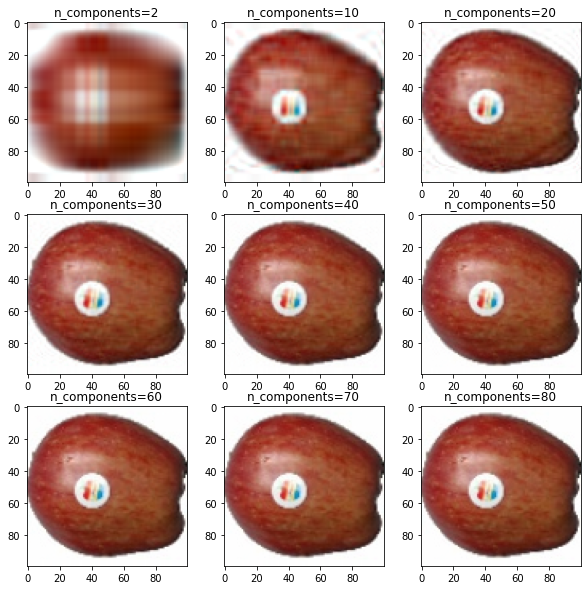

In [ ]:
import random

n_components = [2,10,20,30,40,50,60,70,80]
img_sample = X_image[random.randint(0,len(X_image))]

fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()

for i in range(9):
  img_pca = make_pca(img_sample,n_components[i])
  axes[i].set_title("n_components=" + str(n_components[i]))
  axes[i].imshow(img_pca[:,:,::-1], cmap="Greys")

plt.show()

จากการลดมิติของข้อมูลพบว่า เมื่อเราลดจำนวน components ในรูปผลไม้น้อยเท่าไร รูปภาพจะมีความละเอียดลดลง

แต่เนื่องจากข้อมูลรูปภาพที่ได้มามีจำนวนมากๆ ทำให้ RAM ทำงานหนักมากขึ้น จึงทำให้ไม่สามารถลดมิติของรูปภาพได้ ดังนั้นสร้างชุดข้อมูลที่เก็บค่า RGB โดยทำการแยกสีของรูปภาพออกมาเป็นสีแดง, สีเขียว, สีน้ำเงินตามลำดับ จากนั้นเก็บข้อมูลสีโดยใช้หลักสถิติต่างๆมาคำนวน แล้วนำมา Scaling โดยใช้ Standard Scaler แทน

In [ ]:
from scipy.stats import sem

def create_dataset(image):
  feature = []
  for img in image:
    (R, G, B) = cv2.split(img)
    feature.append([np.mean(R), np.mean(G), np.mean(B),
                    np.std(R), np.std(G), np.std(B),
                    np.median(R), np.median(G), np.median(B),
                    sem(R, axis=None, ddof=0), sem(G, axis=None, ddof=0), sem(B, axis=None, ddof=0),
                    np.percentile(R, 25), np.percentile(G, 25), np.percentile(B, 25),
                    np.percentile(R, 50), np.percentile(G, 50), np.percentile(B, 50),
                    np.percentile(R, 75), np.percentile(G, 75), np.percentile(B, 75)])

  return feature

In [ ]:
X_train = np.array(create_dataset(img_train))
X_test = np.array(create_dataset(img_test))

In [ ]:
y_train = np.array(target_train)
y_test = np.array(target_test)

In [ ]:
np.savetxt('X_train_image.txt', X_train)
np.savetxt('X_test_image.txt', X_test)

np.savetxt('y_train_image.txt', y_train)
np.savetxt('y_test_image.txt', y_test)

save ชุดข้อมูลทั้่งสี่ file ลงใน text file